<a href="https://colab.research.google.com/github/benduong2001/dsproject_font_decorator_bolditalic_unet/blob/main/summer_dsproject_font_decorator_kaggle_unet_bolditalic_v3side_fonttype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.decomposition
import pandas as pd
import os
from PIL import Image
from sklearn.preprocessing import normalize

plt.rcParams['figure.figsize'] = (7,7)

In [2]:
import sklearn.neighbors
import sklearn.manifold
from sklearn.cluster import KMeans

from tqdm import tqdm

In [3]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
PATH_FOLDER = "/content/drive/MyDrive/dsprojects/dsproject_imagery/dsprojects_fonts/"
font_folder_path = PATH_FOLDER + "/fonts/"
uci_font_family_csv_file_names = os.listdir(font_folder_path) # list of file_names. Each file is the csv for a specific font

In [5]:
# for each font's csv table, the column "m_label" denotes an identifier for a certain character
# the variables below are the m_labels for specific character groups (alphanumeric - uppercase, lowercase, digits)
MIN_M_LABEL = 33
MAX_M_LABEL = 126
m_labels_all = list(range(MIN_M_LABEL,MAX_M_LABEL+1))
m_labels_alphanum_alpha_upper = list(range(m_labels_all[32], m_labels_all[32+26]))
m_labels_alphanum_alpha_lower = list(range(m_labels_all[64], m_labels_all[64+26]))
m_labels_alphanum_num = list(range(m_labels_all[16], m_labels_all[16+10]))

# each row of the csv table has a 20x20 image for the character it represents, which can be made using a group of 400 columns. These column names are collected here for future use
pixel_column_names = []
for i in range(0, 20):
    for j in range(0, 20):
        pixel_column_name = "r{0}c{1}".format(str(i),str(j))
        pixel_column_names.append(pixel_column_name)

# for this unsupervised classification, I'm going to just use the 26 capital letters to represent each font
# My main reason is that capital letters are arguably square-shaped and thus proportionally consistent in anatomy for most fonts.
# Because in this dataset, thin or wide characters get forcibly stretched or narrowed to fit a 20x20 space. 
# But you can change which characters you want to use below. 
CHOSEN_M_LABELS = []
CHOSEN_M_LABELS += m_labels_alphanum_alpha_upper
#CHOSEN_M_LABELS += m_labels_alphanum_alpha_lower
#CHOSEN_M_LABELS += m_labels_alphanum_num


CHARACTERS_AMOUNT = len(CHOSEN_M_LABELS)
# I'm going to iterate through each font file
# 


In [6]:
def temp_create_channels(channel_type):
    # channel_type is 1 for italic, 2 for bold, 3 for both
    DIM1 = 20
    DIM2 = 20
    if channel_type == 0:
        return np.zeros((DIM1,DIM2))
    elif channel_type == 3:
        return temp_create_channels(1) + temp_create_channels(2)
    else:
        channel = np.zeros((DIM1,DIM2))
        ohe_divisions = 2
        span = DIM1//ohe_divisions

        span_idx = channel_type-1
        start = (span_idx*span)
        stop = (start+span)
        channel[(start):(stop),:] = 1
        return channel

In [7]:
serifed_fonts = ['BODONI', 'BOOK', 'BOOKMAN', 'BAITI', 'BELL', 'BASKERVILLE',
       'CAMBRIA', 'CALISTO', 'CENTURY', 'CALIFORNIAN', 'CENTAUR',
       'CASTELLAR', 'CONSTANTIA', 'COMPLEX', 'COURIER', 'EUROROMAN',
       'ENGLISH', 'ENGRAVERS', 'FOOTLIGHT', 'FELIX TITLING', 'DUTCH801',
       'CURLZ', 'GABRIOLA', 'GOTHICE', 'GEORGIA', 'GARAMOND', 'GOUDY',
       'HIGH TOWER', 'HARRINGTON', 'IMPRINT', 'HIMALAYA', 'LUCIDA',
       'KRISTEN', 'JUICE', 'JAVANESE', 'NIAGARA', 'MODERN', 'MINGLIU',
       'PALATINO', 'PANROMAN', 'RICHARD', 'PERPETUA', 'PMINGLIU-EXTB',
       'ROMANTIC', 'SITKA', 'SYLFAEN', 'SUPERFRENCH', 'TIMES']

In [8]:
sanserifed_fonts = ['ARIAL', 'AGENCY', 'BAUHAUS', 'BERNARD', 'BRITANNIC', 'BERLIN',
       'BITSTREAMVERA', 'BANKGOTHIC', 'BUXTON', 'CAARD', 'BROADWAY',
       'CALIBRI', 'CANDARA', 'CONSOLAS', 'COMIC', 'CORBEL', 'COPPERPLATE',
       'COOPER', 'EBRIMA', 'ERAS', 'ELEPHANT', 'GADUGI', 'FORTE',
       'FRANKLIN', 'HAETTENSCHWEILER', 'GILL', 'GUNPLAY', 'GLOUCESTER',
       'IMPACT', 'LEELAWADEE', 'MAIANDRA', 'JOKERMAN', 'MISTRAL',
       'MONOSPAC821', 'MYANMAR', 'NINA', 'NIRMALA', 'OCRA', 'ONYX',
       'OCRB', 'PHAGSPA', 'RAVIE', 'ROCKWELL', 'PLAYBILL', 'REFERENCE',
       'QUICKTYPE', 'SANSSERIF', 'SERIF', 'SEGOE', 'SHOWCARD', 'SNAP',
       'STENCIL', 'SWIS721', 'TECHNIC', 'TREBUCHET', 'TEMPUS', 'TAHOMA',
       'TAI', 'TW', 'VINETA', 'VERDANA', 'YI BAITI', 'WIDE']

In [9]:
allowed_font_families = []
allowed_font_families += serifed_fonts
allowed_font_families += sanserifed_fonts

In [10]:
x_train = []
x_test = []
y_train = []
y_test = []
np.random.seed(1)
range_len_uci_font_family_csv_file_names = range(len(allowed_font_families))
range_len_uci_font_family_csv_file_names = tqdm(range_len_uci_font_family_csv_file_names)

for i in range_len_uci_font_family_csv_file_names:
    uci_font_family = allowed_font_families[i]
    uci_font_family_csv_file_name = uci_font_family+".csv"
    if uci_font_family in ['BITSTREAMVERA','CREDITCARD', 'E13B', 'HANDPRINT', 'MONEY', 'NUMERICS', 'VIN']:
        continue
    
    temp_uci_font_family_df_orig = pd.read_csv(font_folder_path + uci_font_family_csv_file_name)
    # choose characters
    temp_uci_font_family_df_orig = temp_uci_font_family_df_orig[temp_uci_font_family_df_orig["m_label"].isin(CHOSEN_M_LABELS)]
    # sort for easiness (each of the m_label, whichever you chose, are now separated)
    temp_uci_font_family_df_orig = temp_uci_font_family_df_orig.sort_values(["m_label","strength",	"italic"])
    temp_uci_font_family_df_orig = temp_uci_font_family_df_orig.drop_duplicates(subset=["m_label","strength",	"italic"])
    
    # forloop for each character,
    # for each character, read and reshape the pixel columns, and design the concatenated channel(s) for italic, bold, and both
    # then fill the x_train, y_train, x_test, y_test lists, by choosing on the spot if it likes to be in either
    available_m_labels = temp_uci_font_family_df_orig["m_label"]

    temp_uci_font_family_df_orig[pixel_column_names] = temp_uci_font_family_df_orig[pixel_column_names].astype(float)
    temp_uci_font_family_df_orig[pixel_column_names] /= 255

    assert temp_uci_font_family_df_orig.shape[0] == 26*4

    for m_label_idx in range(len(available_m_labels)):
        # iterate through the m_labels of the font, which will include regular form, and bold/italic forms
        temp_m_label = available_m_labels.values[m_label_idx]
        temp_m_label_df = temp_uci_font_family_df_orig[temp_uci_font_family_df_orig["m_label"] == temp_m_label]
        # this should be up to 4 rows
        assert temp_m_label_df.shape[0] == 4

        temp_m_label_df_pixels = temp_m_label_df[pixel_column_names].values.reshape((4,20,20))

        regular_form_arr = temp_m_label_df_pixels[0]
        italic_form_arr = temp_m_label_df_pixels[1]
        bold_form_arr = temp_m_label_df_pixels[2]
        bold_italic_form_arr = temp_m_label_df_pixels[3]

        # now dealing with the concatenation process. this is difficult
        temp_target_form_arr_list = [regular_form_arr,italic_form_arr,bold_form_arr,bold_italic_form_arr]
        for channel_type_idx in range(len(temp_target_form_arr_list)):
            temp_target_form_arr = temp_target_form_arr_list[channel_type_idx]
            # channel_type is 1 for italic, 2 for bold, 3 for both,0 for reg
            channel_type = channel_type_idx #+ 1 # don't change

            temp_channel = temp_create_channels(channel_type)

            # reshape so that it is now (20, 20, 1 + # of channels)
            temp_regular_form_concat = np.hstack([regular_form_arr,temp_channel])
            temp_regular_form = np.expand_dims(temp_regular_form_concat,2)

            temp_target_form_concat = np.hstack([temp_target_form_arr,temp_channel])
            # change target image from 2d array to 1-channel 3d array
            temp_target_form = np.expand_dims(temp_target_form_concat,2)

            # decide if train or test:
            train_test_decider = np.random.choice([1,0],size=1, p=[0.75, 0.25])[0]
            if train_test_decider:
                x_train.append(temp_regular_form)
                y_train.append(temp_target_form)
            else:
                x_test.append(temp_regular_form)
                y_test.append(temp_target_form)

 64%|██████▍   | 71/111 [00:56<00:27,  1.45it/s]/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
100%|██████████| 111/111 [01:37<00:00,  1.13it/s]


In [11]:
len(x_train), len(y_train),len(x_test), len(y_test),

(34307, 34307, 11453, 11453)

In [12]:
x_train[0].shape, y_train[0].shape, x_test[0].shape, y_test[0].shape

((20, 40, 1), (20, 40, 1), (20, 40, 1), (20, 40, 1))

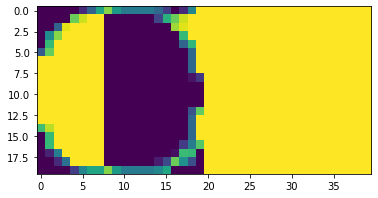

In [15]:
imx = 28
plt.imshow(np.squeeze((x_train[imx]*255).astype(int)))

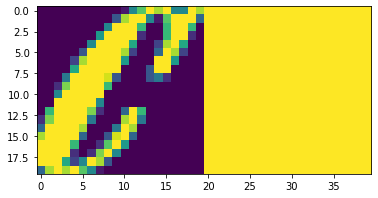

In [16]:
plt.imshow(np.squeeze((y_train[imx]*255).astype(int)))

In [17]:
import pickle        

In [18]:
f = open(PATH_FOLDER+'unet_font_x_train_v3_serifsan.pkl', 'wb') 
pickle.dump(x_train, f)
f.close()     
f = open(PATH_FOLDER+'unet_font_y_train_v3_serifsan.pkl', 'wb') 
pickle.dump(y_train, f)
f.close()     

In [19]:
f = open(PATH_FOLDER+'unet_font_x_test_v3_serifsan.pkl', 'wb') 
pickle.dump(x_test, f)
f.close()     
f = open(PATH_FOLDER+'unet_font_y_test_v3_serifsan.pkl', 'wb') 
pickle.dump(y_test, f)
f.close()     